In [7]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../../')
import photPack2
from astropy.time import Time
import emcee

## Read in raw data, organize
rawch1 = np.genfromtxt('secondPLD/wasp6_channel1.ascii')
rawch2 = np.genfromtxt('secondPLD/wasp6_channel2.ascii')

ch1 = {}
ch2 = {}
for rawdata, output in zip([rawch1, rawch2], [ch1, ch2]):
    for i, key, offset in zip(range(3), ['t', 'f', 'e'], [2450000.0, 0.0, 0.0]):
        output[key] = rawdata[:,i] + offset

for ch in [ch1, ch2]:
    ch['e'] = np.zeros_like(ch['f']) + np.std(ch['f'][int(0.66*len(ch['f'])):])

## Double check that time offset is what I think it is, by subtracting the start time
## of the observations shown on the Spitzer Heritage Archive to the start time of the data:
# print Time('2013-01-21 08:23:00', format='iso', scale='utc').jd - ch1['t'].min() + 0.00195

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [10]:
import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad

def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    #calculates separation of centers between the planet and the star
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   
    #returns limb darkened model lightcurve
    mu_c = occultquad(z0, u1, u2, p0, npoints)   
    return F0*mu_c

def T14b2aRsi(P, T14, b):
    '''
    Convert from duration and impact param to a/Rs and inclination
    '''
    i = np.arccos( ( (P/np.pi)*np.sqrt(1 - b**2)/(T14*b) )**-1 )
    aRs = b/np.cos(i)
    return aRs, i

def aRsi2T14b(P, aRs, i):
    b = aRs*np.cos(i)
    T14 = (P/np.pi)*np.sqrt(1-b**2)/aRs
    return T14, b

def reparameterized_lc(T14, b, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    Reparameterization of the transit light curve in `get_lc()` with
    duration (first-to-fourth contact) instead of a/R* and impact
    parameter instead of inclination
    '''
    aRs, i = T14b2aRsi(period, T14, b)
    return get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t)


from scipy import optimize
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0.0 # Husnoo 2012
inclination = 88.47*np.pi/180
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2 # To match e=0, from Husnoo 2012
period = 3.36100239 # Nikolov 2015          #3.361006
mineccentricity = 1.0e-7
t0_roughfit = 2456918.8793039066

Nbins = 8
Nlightcurves = Nbins + 2

lastp = 0

mosfire_meantimediff = airmass = ch1['t']
ch1_meantimediff = np.median(np.diff(ch1['t']))
ch2_meantimediff = np.median(np.diff(ch2['t']))
#mosfire_exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds
def fine_lc(T, b, t0, q1, q2, p0, F0, e, w, period, eps, t, meantimediff):
    new_t = np.linspace(t.min() - 2*meantimediff, t.max() + 2*meantimediff, 5*len(t))
    #return new_t, get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, new_t)
    return new_t, reparameterized_lc(T, b, t0, q1, q2, p0, F0, e, w, period, eps, new_t)

def binned_lc(T, b, t0_roughfit, q1, q2, RpOverRs, F0, am, eccentricity, 
              periapse, period, eps, t, meantimediff, airmassvector=airmass):
    new_t, finemodel = fine_lc(T, b, t0_roughfit, q1, q2, RpOverRs, 
                               F0, eccentricity, periapse, period, eps, t, meantimediff)
    exptime = t[1] - t[0]
    timebinedges = np.sort(np.concatenate([t - 0.5*exptime, t + 0.5*exptime]))
    d = np.digitize(new_t, timebinedges)
    binned_model = np.array([np.mean(finemodel[d == i]) for i in range(1, 2*len(t), 2)])
    if airmassvector is None:
        return binned_model
    else:
        return binned_model*(1 + (airmassvector - 1)/am)


In [17]:
def genmodel(parameters, Nbins=Nbins):
#     mosfiremodel = np.zeros_like(lightcurve)
    listparams = parameters.tolist()

#     for eachbin in xrange(Nbins):
#         mosfirelcparams = listparams[0:3] + listparams[4:6] + \
#                     [parameters[10+eachbin], parameters[20+eachbin], np.exp(parameters[30+eachbin]), eccentricity, \
#                      periapse, period, 1e-7, times, mosfire_meantimediff] # Fixed params
        
#         mosfiremodel[:,eachbin] = binned_lc(*mosfirelcparams)
    
    spitzeram = [np.e] # placeholder argument, ignored
    ch1lcparams = listparams[0:2] + [parameters[3]] + listparams[6:8] + \
                  listparams[18:19] + listparams[28:29] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch1['t'], ch1_meantimediff]
    
    ch2lcparams = listparams[0:2] + [parameters[3]] + listparams[8:10]  + \
                  listparams[19:20] + listparams[29:30] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch2['t'], ch2_meantimediff]

    ch1model = binned_lc(*ch1lcparams, airmassvector=None)
    ch2model = binned_lc(*ch2lcparams, airmassvector=None)
    return ch1model, ch2model
    #return mosfiremodel, ch1model, ch2model

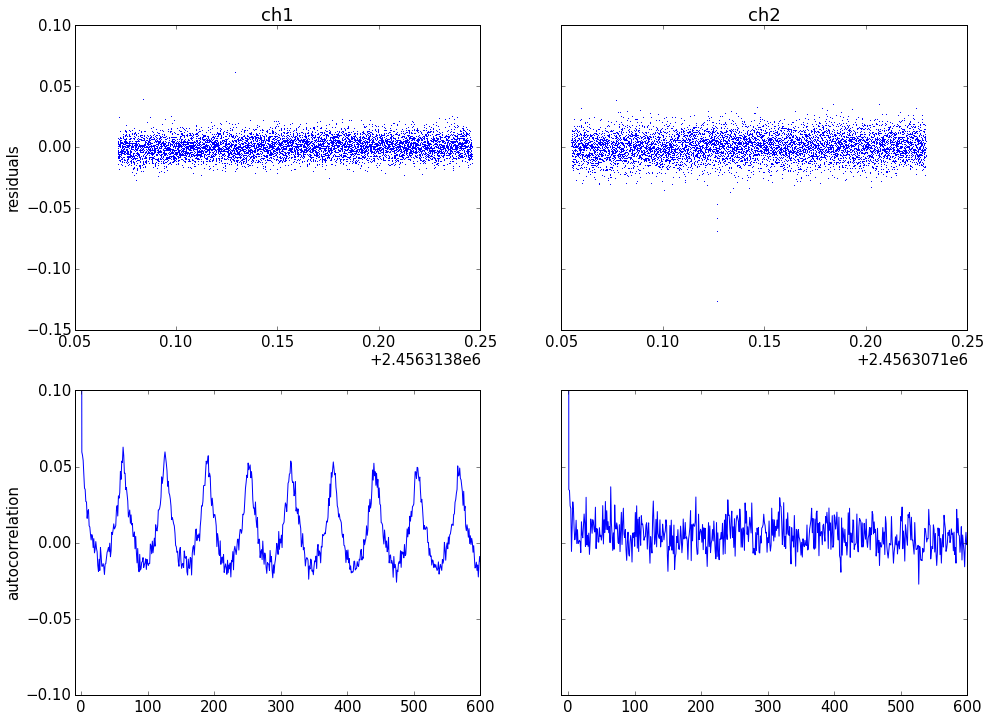

In [41]:
spitzwhitekernelall_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_201503040921.npy') 

spitzwhitekernelall_params[:2] = aRsi2T14b(period, spitzwhitekernelall_params[0], spitzwhitekernelall_params[1])
ch1model, ch2model = genmodel(spitzwhitekernelall_params)

fig, ax = plt.subplots(2, 2, figsize=(16,12), sharey='row')
ax[0, 0].plot(ch1['t'], ch1['f'] - ch1model,',')
ax[0, 1].plot(ch2['t'], ch2['f'] - ch2model,',')

a1 = autocorr(ch1['f'] - ch1model)
a2 = autocorr(ch2['f'] - ch2model)
ax[1, 0].plot(a1)
ax[1, 1].plot(a2)

# testrs = np.arange(len(a1))
# expsquared = lambda r, sig: np.exp(-0.5*r**2/sig**2)
# cosine = lambda r, p: np.cos(2*np.pi*r/p)

# def kernel(params, r=testrs):
#     amp, p, sig = params
#     return amp*expsquared(r, sig)*cosine(r,p)

# def errfunc(params, y):
#     return kernel(params) - y

# initP = [0.1, 55, 10000]
# bestp = optimize.leastsq(errfunc, initP, args=(a1))[0]
# print bestp

# ax[1, 0].plot(kernel(bestp))

ax[1, 0].set_ylim([-0.1, 0.1])

ax[1, 0].set_xlim([-10, 600])
ax[1, 1].set_xlim([-10, 600])

ax[0, 0].set_title('ch1')
ax[0, 1].set_title('ch2')
ax[0, 0].set_ylabel('residuals')
ax[1, 0].set_ylabel('autocorrelation')
fig.savefig('secondpld.png')
plt.show()